In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d

import sampledata

name = "SimPEG-Original"

In [2]:
%matplotlib widget

In [3]:
rec_x = (np.arange(20)-10)*200+100
rec = emg3d.surveys.txrx_coordinates_to_dict(emg3d.RxElectricPoint, (rec_x, 0, -800, 0, 0))

src_x = np.array([-1900, -1500, -1100, -700, 700, 1100, 1500, 1900])
src = emg3d.surveys.txrx_coordinates_to_dict(emg3d.TxElectricDipole, (src_x, -100, -900, 0, 0))

survey = emg3d.surveys.Survey(
    sources=src,
    receivers=rec,
    frequencies=2.0,
    noise_floor=1e-14,
    relative_error=0.01,
)
survey

:: Survey ::

<xarray.Dataset> Size: 3kB
Dimensions:   (src: 8, rec: 20, freq: 1)
Coordinates:
  * src       (src) <U6 192B 'TxED-1' 'TxED-2' 'TxED-3' ... 'TxED-7' 'TxED-8'
  * rec       (rec) <U7 560B 'RxEP-01' 'RxEP-02' ... 'RxEP-19' 'RxEP-20'
  * freq      (freq) <U3 12B 'f-1'
Data variables:
    observed  (src, rec, freq) complex128 3kB (nan+nanj) ... (nan+nanj)
Attributes:
    noise_floor:     1e-14
    relative_error:  0.01

In [4]:
grid = emg3d.TensorMesh([np.ones(22)*200, np.ones(20)*200, np.ones(16)*200], x0=(-2200, -2000, -3000))
grid

TensorMesh: 7,040 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     22     -2,200.00      2,200.00    200.00    200.00    1.00
   y     20     -2,000.00      2,000.00    200.00    200.00    1.00
   z     16     -3,000.00        200.00    200.00    200.00    1.00

In [5]:
sigma = np.ones(grid.shape_cells)
sigma[:, :, -1] = 1/1e8        # air
sigma[:, :, -6:-1] = 1/0.33    # sea-water
model_init = emg3d.Model(grid, sigma.copy(), mapping='Conductivity')
sigma[6:-6, 1:-1, 6] = 1/100  # target
model = emg3d.Model(grid, sigma.copy(), mapping='Conductivity')
sigma = sigma.ravel('F')
model_init

Model: conductivity; isotropic; 22 x 20 x 16 (7,040)

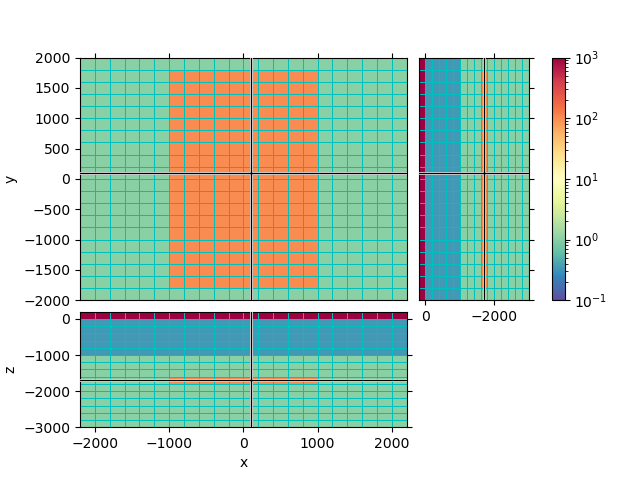

In [6]:
grid.plot_3d_slicer(
    1/model.property_x, zslice=-1600,
    pcolor_opts={
        'cmap': 'Spectral_r',
        'norm': LogNorm(vmin=.1, vmax=1000), 'lw': 0.5, 'color': 'c',
    },
)
fig = plt.gcf()
fig.axes[0].set_title('Resistivity Model')
fig.axes[0].plot(rec_x, rec_x*0, 'bo')
fig.axes[0].plot(src_x, src_x*0, 'w*')

In [7]:
# Create an emg3d Simulation instance
sim = emg3d.simulations.Simulation(
    survey=survey.copy(),
    model=model,
    gridding='both',
    max_workers=9,
    gridding_opts={'vector': 'xyz'},
    solver_opts={'tol_gradient': 1e-3},
    receiver_interpolation='linear',
    tqdm_opts=False,
)
sim

:: Simulation ::

- Survey: 8 sources; 20 receivers; 1 frequencies
- Model: conductivity; isotropic; 22 x 20 x 16 (7,040)
- Gridding: Frequency- and source-dependent grids; 48 x 48 x 32 (73,728)

Data saved to «/home/dtr/Codes/devInv/data/SimPEG-Original.h5»
[emg3d v1.8.4.dev11+g36578d6 (format 1.0) on 2024-09-02T15:23:28.655393].
Data loaded from «/home/dtr/Codes/devInv/data/SimPEG-Original.h5»
[emg3d v1.8.4.dev11+g36578d6 (format 1.0) on 2024-09-02T15:23:28.655393].


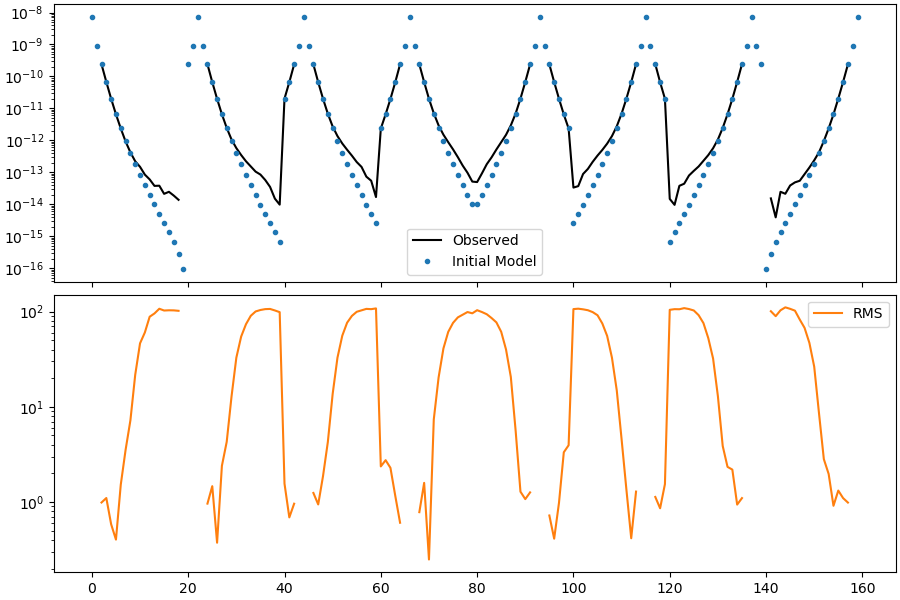

In [8]:
sampledata.create_data(name, sim, model_init, min_offset=300)
sampledata.plot_obs_initial(name)

In [9]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Mon Sep 02 15:23:29 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC
  12.3.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.60.0
             emg3d : 1.8.4.dev11+g36578d6
           empymod : 2.3.2.dev7+g2133d34.d20240729
            xarray : 2024.6.0
        discretize : 0.10.1.dev15+gf89e5ff7.d20240902
              h5py : 3.11.0
        matplotlib : 3.9.0
              tqdm : 4.66.4
           IPython : 8.26.0
--------------------------------------------------------------------------------